# Détermination des trajectoires similaires

In [1]:
%matplotlib inline
from nuscenes.nuscenes import NuScenes
nusc = NuScenes(version='v1.0-mini', dataroot='/Users/tiffanydarini/nuscenes-devkit/python-sdk/tutorials/data/sets/nuscenes/v1.0-mini', verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.310 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


### Étape 1 : Récupération des données sur le véhicule ego

In [2]:
# Fonction qui renvoie les tables ego_pose d'une scène donnée
def get_poses(scene_token):
    pose_list = []
    scene_rec = nusc.get('scene', scene_token)
    sample_rec = nusc.get('sample', scene_rec['first_sample_token'])
    sd_rec = nusc.get('sample_data', sample_rec['data']['LIDAR_TOP'])
    
    ego_pose = nusc.get('ego_pose', sd_rec['token'])
    pose_list.append(ego_pose)

    while sd_rec['next'] != '':
        sd_rec = nusc.get('sample_data', sd_rec['next'])
        ego_pose = nusc.get('ego_pose', sd_rec['token'])
        pose_list.append(ego_pose)

    return pose_list

In [3]:
# On utilise ce qu'on a déjà (liste ego_poses)
scene_name = 'scene-0061'
scene_token = nusc.field2token('scene','name',scene_name)[0]
Liste_ego_poses = get_poses(scene_token) 

# Création des liste de coordonnées du véhicule égo 
X_coord =[]
Y_coord =[]
Z_coord =[]
T_timestamp = [] # liste des timestamps
for k in range(0,len(Liste_ego_poses)):
    X_coord.append(Liste_ego_poses[k]['translation'][0])
    Y_coord.append(Liste_ego_poses[k]['translation'][1])
    Z_coord.append(Liste_ego_poses[k]['translation'][2])
    T_timestamp.append(Liste_ego_poses[k]['timestamp'])

### Étape 2 : On récupère les échantillons de la scène 

In [4]:
# Ensemble des token des échantillons de la scene 
sample_token = nusc.field2token('sample','scene_token',scene_token)
len(sample_token)

39

### Étape 3 : On récupère les sample_annotation de la scène (boites d'objets dans la scène)

In [5]:
# Ensemble des sample_annotation de la scène :

sample_annotation_token = []
for k in sample_token : 
    L = nusc.field2token('sample_annotation','sample_token',k)
    sample_annotation_token = sample_annotation_token + L

### Étape 4 : Liste des instances dans la scène

In [6]:
# On créé la liste des token des instances présents dans les sample_annotation
L_instance_token = []
for k in sample_annotation_token :
    exemple = nusc.get('sample_annotation', k)
    L_instance_token.append(exemple['instance_token'])

In [7]:
# Puisque pour un même objet, on peut avoir plusieurs annotations, on supprime les doublons de L
L_instance_token = list(set(L_instance_token))
len(L_instance_token)
print('Il y a '+str(len(L_instance_token))+' instances dans la scène ' +scene_name)

Il y a 227 instances dans la scène scene-0061


### Étape 5 : Séparation de chaque catégorie 

In [8]:
# Liste des catégories d'objet dans la scène 
L_category_name = []
for k in sample_annotation_token :
    exemple = nusc.get('sample_annotation', k)
    L_category_name.append(exemple['category_name'])
L_category_name = list(set(L_category_name))
L_category_name

['vehicle.bicycle',
 'vehicle.truck',
 'movable_object.trafficcone',
 'movable_object.pushable_pullable',
 'vehicle.motorcycle',
 'human.pedestrian.construction_worker',
 'vehicle.car',
 'movable_object.debris',
 'vehicle.bus.rigid',
 'vehicle.construction',
 'human.pedestrian.adult',
 'movable_object.barrier']

In [9]:
# Pour l'instant, travail à la main pour chaque catégorie trouvée
k = 6
catego_name = L_category_name[k]
catego_token = nusc.field2token('category','name',catego_name)
category = nusc.get('category',catego_token[0])
category

{'token': 'fd69059b62a3469fbaef25340c0eab7f',
 'name': 'vehicle.car',
 'description': 'Vehicle designed primarily for personal use, e.g. sedans, hatch-backs, wagons, vans, mini-vans, SUVs and jeeps. If the vehicle is designed to carry more than 10 people use vehicle.bus. If it is primarily designed to haul cargo use vehicle.truck. '}

In [10]:
# Ensemble des instances appartenant à la fois à la scène et à la catégorie
L_instance_category = nusc.field2token('instance','category_token',catego_token[0]) # instance dans la catégorie
L_instance_category = [x for x in L_instance_category if x in L_instance_token]# et dans la scène 

In [11]:
L=[]
for k in L_instance_category : 
    instance_category = nusc.get('instance',k)
    nbr_annotations = instance_category['nbr_annotations']
    if nbr_annotations == 1:
        L.append([instance_category['first_annotation_token']])
    else : 
        H = []
        first_token = instance_category['first_annotation_token']
        last_token = instance_category['last_annotation_token']
        current_token = first_token 
        
        i = 0 
        while i!= nbr_annotations :
            current_ann = nusc.get('sample_annotation', current_token)
            H.append(current_ann['token'])
            current_token = current_ann['next'] #On passe au suivant
            i+=1
        L.append(H)
# Il peut y avoir plusieurs éléments de la catégorie dans la scène, ici chaque ligne de L représente 
# les token des sample_annotation pour un élément de cette catégorie. 

In [12]:
# Maintenant qu'on a les token de tous les sample_annotation pour tous les éléments d'une même catégorie, 
# on va pouvoir récupérer leurs positions 

X = []
Y = []
Z = []
T_time = []
for k in L :
    x = []
    y = []
    z = []
    t = []
    for j in k :
        sample_annotation = nusc.get('sample_annotation',j)
        x.append(sample_annotation['translation'][0])
        y.append(sample_annotation['translation'][1])
        z.append(sample_annotation['translation'][2])
        t.append(nusc.get('sample',sample_annotation['sample_token'])['timestamp'])
    X.append(x)
    Y.append(y)
    Z.append(z)
    T_time.append(t)

### Étape 6 : Fonction pour savoir si un objet est immobile ou pas 

In [13]:
# On crée une fonction qui renvoie la liste des rangs dans les listes X,Y des objets immobiles de 
# cette liste et donc d'une même catégorie, ainsi que la liste des objets mobiles 
from math import sqrt

def immobile(X,Y):
    Immo = []
    Mobile = []
    n = len(X) # Nombre d'élément dans la catégorie 
    for i in range(0,n-1):
        X_coord = X[i]
        Y_coord = Y[i]
        if len(X_coord)==1 :
            Immo.append(i)
        else : 
            d = 0 
            for k in range(0,len(X_coord)-1):
                d+= sqrt((X_coord[k+1]-X_coord[k])**2+(Y_coord[k+1]-Y_coord[k])**2)
            if d<2 : # Si la distance totale parcourue par l'objet est inférieur à 2m, on considère que l'objet bouge pas
                Immo.append(i)
            else :
                Mobile.append(i)
    return Immo,Mobile  

In [14]:
Immo, Mobile = immobile(X,Y)
len(Mobile)

5

### Étape 7 : On garde uniquement les objets mobiles

In [15]:
# On conserve uniquement les objets mobiles 
X_mobile=[X[i] for i in Mobile]
Y_mobile=[Y[i] for i in Mobile]
Z_mobile=[Z[i] for i in Mobile]
T_mobile = [T_time[i] for i in Mobile]
len(X_mobile)

5

### Étape 8 : Package DTW

In [16]:
from dtw import *
?dtw
help(DTW)

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.

Help on class DTW in module dtw.dtw:

class DTW(builtins.object)
 |  DTW(obj)
 |  
 |  The results of an alignment operation.
 |  
 |  Objects of class DTW contain alignments computed by the [dtw()]
 |  function. 
 |  
 |  **Attributes:**
 |  
 |  - ``distance`` the minimum global distance computed, *not* normalized.
 |  - ``normalizedDistance`` distance computed, *normalized* for path
 |    length, if normalization is known for chosen step pattern.
 |  - ``N,M`` query and reference length
 |  - ``call`` the function call that created the object
 |  - ``index1`` matched elements: indices in ``x``
 |  - ``index2`` corresponding mapped indices in ``y``
 |  - ``stepPattern`` the ``stepPattern`` object used for the computation
 |  - ``jmin`` last element of reference matched, if ``op

In [ ]:
# On va le faire à la main :

In [ ]:
### On commence par construire la matrice de distance entre les 2 trajectoires
### On met un véhicule de la scène sur les lignes et le véhicule ego en colonne 

In [17]:
import numpy as np 
from math import sqrt 

# Fonction qui renvoie la matrice des distances 
def Matrice_distance(X_ego,Y_ego,X_veh,Y_veh):
    M = np.zeros((len(X_veh),len(X_ego)))
    for i in range(0,len(X_veh)):
        for j in range(0,len(X_ego)):
            M[i,j] = sqrt((X_veh[len(X_veh)-1-i]-X_ego[j])**2+(Y_veh[len(Y_veh)-1-i]-Y_ego[j])**2)
    return M 
     

In [122]:
M_distance = Matrice_distance(X_coord,Y_coord,X_mobile[3],Y_mobile[3])
#M_distance=M_distance.T
M_distance

array([[75.72889821, 75.3512346 , 74.97456416, ...,  9.01662935,
         8.92903248,  8.84112219],
       [76.29447888, 75.91481774, 75.53614606, ...,  8.3987464 ,
         8.30819605,  8.21734478],
       [76.91610711, 76.53386342, 76.15260628, ...,  7.62480023,
         7.53097924,  7.4368755 ],
       ...,
       [44.26841129, 43.81408127, 43.36134226, ..., 40.6181984 ,
        40.69038204, 40.76202553],
       [41.61987478, 41.16560112, 40.7129149 , ..., 42.28226303,
        42.35085983, 42.41888444],
       [39.03084866, 38.57664508, 38.1240249 , ..., 43.99773929,
        44.0629442 , 44.12754827]])

In [123]:
from dtw import *
alignment = dtw(M_distance)

In [124]:
alignment.distance

10546.840656812688

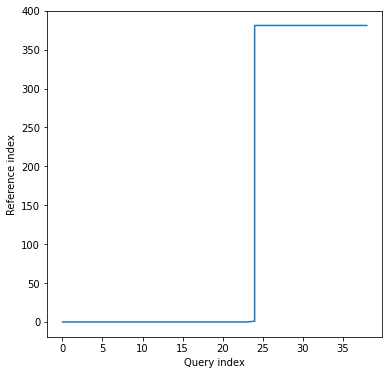

<AxesSubplot:xlabel='Query index', ylabel='Reference index'>

In [125]:
alignment.plot()

In [112]:
import matplotlib.pyplot as plt

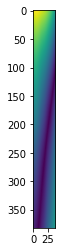

In [128]:
ax = plt.imshow(M_distance.T)
#ax.set_aspect('equal', adjustable='box')

In [129]:
M_distance

array([[75.72889821, 75.3512346 , 74.97456416, ...,  9.01662935,
         8.92903248,  8.84112219],
       [76.29447888, 75.91481774, 75.53614606, ...,  8.3987464 ,
         8.30819605,  8.21734478],
       [76.91610711, 76.53386342, 76.15260628, ...,  7.62480023,
         7.53097924,  7.4368755 ],
       ...,
       [44.26841129, 43.81408127, 43.36134226, ..., 40.6181984 ,
        40.69038204, 40.76202553],
       [41.61987478, 41.16560112, 40.7129149 , ..., 42.28226303,
        42.35085983, 42.41888444],
       [39.03084866, 38.57664508, 38.1240249 , ..., 43.99773929,
        44.0629442 , 44.12754827]])

In [111]:
dtw(M_distance, keep_internals=True).plot(type="twoway",offset=-2)

ValueError: Original timeseries are required

In [87]:
# Pour avoir les coordonnées des points du chemin :
Chemin = [[alignment.index1[k],alignment.index2[k]] for k in range(0,len(alignment.index1))]
Chemin

[[0, 0],
 [1, 0],
 [2, 0],
 [3, 0],
 [4, 0],
 [5, 0],
 [6, 0],
 [7, 0],
 [8, 0],
 [9, 0],
 [10, 0],
 [11, 0],
 [12, 1],
 [12, 2],
 [12, 3],
 [12, 4],
 [12, 5],
 [12, 6],
 [12, 7],
 [12, 8],
 [12, 9],
 [12, 10],
 [12, 11],
 [12, 12],
 [12, 13],
 [12, 14],
 [12, 15],
 [12, 16],
 [12, 17],
 [12, 18],
 [12, 19],
 [12, 20],
 [12, 21],
 [12, 22],
 [12, 23],
 [12, 24],
 [12, 25],
 [12, 26],
 [12, 27],
 [12, 28],
 [12, 29],
 [12, 30],
 [12, 31],
 [12, 32],
 [12, 33],
 [12, 34],
 [12, 35],
 [12, 36],
 [12, 37],
 [12, 38],
 [12, 39],
 [12, 40],
 [12, 41],
 [12, 42],
 [12, 43],
 [12, 44],
 [12, 45],
 [12, 46],
 [12, 47],
 [12, 48],
 [12, 49],
 [12, 50],
 [12, 51],
 [12, 52],
 [12, 53],
 [12, 54],
 [12, 55],
 [12, 56],
 [12, 57],
 [12, 58],
 [12, 59],
 [12, 60],
 [12, 61],
 [12, 62],
 [12, 63],
 [12, 64],
 [12, 65],
 [12, 66],
 [12, 67],
 [12, 68],
 [12, 69],
 [12, 70],
 [12, 71],
 [12, 72],
 [12, 73],
 [12, 74],
 [12, 75],
 [12, 76],
 [12, 77],
 [12, 78],
 [12, 79],
 [12, 80],
 [12, 81],
 [12, 82

In [23]:
distancebis= sum([M_distance[i,j] for [i,j] in Chemin])
distancebis

10481.959613516481

In [ ]:
# Regardons si le facteur dans normalized est constant 

In [80]:
M_distance1 = Matrice_distance(X_coord,Y_coord,X_mobile[0],Y_mobile[0])
M_distance2 = Matrice_distance(X_coord,Y_coord,X_mobile[3],Y_mobile[3])

In [81]:
alignment1 = dtw(M_distance1)
alignment2 = dtw(M_distance2)

In [82]:
a = alignment1.distance / alignment1.normalizedDistance
a

385.0

In [96]:
M_distance1.shape

(3, 382)

In [84]:
b = alignment2.distance / alignment2.normalizedDistance
b

421.0

In [95]:
M_distance2.shape

(39, 382)

In [ ]:
# => Le normalized divise la distance DTW par la somme des dimensions de
# la matrice des distances

### Étape 9 : Automatisation 

In [ ]:
# Création d'une fonction qui renvoie une df contenant la dtw de 
# chaque véhicule d'une scène par raport au véhicule ego 

In [24]:
## En utilisant le package 

#imports nécessaires
import matplotlib.pyplot as plt
from math import sqrt
import datetime 
from datetime import timedelta
from dtw import *
import pandas as pd

def dtw_distance(scene_name):
    
    # On crée une dataframe vide 
    df = pd.DataFrame()
    
    scene_token = nusc.field2token('scene','name',scene_name)[0]
    sample_token = nusc.field2token('sample','scene_token',scene_token)# Ensemble des token des échantillons de la scene 
    
    # Pour tracer la trajectoire du véhicule ego
    Liste_ego_poses = get_poses(scene_token) 
    X_coord =[]
    Y_coord =[]
    Z_coord =[]
    T_timestamp = [] # liste des timestamps
    for k in range(0,len(Liste_ego_poses)):
        X_coord.append(Liste_ego_poses[k]['translation'][0])
        Y_coord.append(Liste_ego_poses[k]['translation'][1])
        Z_coord.append(Liste_ego_poses[k]['translation'][2])
        T_timestamp.append(Liste_ego_poses[k]['timestamp'])

    # Ensemble des sample_annotation de la scène :
    sample_annotation_token = []
    for k in sample_token : 
        L = nusc.field2token('sample_annotation','sample_token',k)
        sample_annotation_token = sample_annotation_token + L
    
    # On créé la liste des token des instances présents dans les sample_annotation
    L_instance_token = []
    for k in sample_annotation_token :
        exemple = nusc.get('sample_annotation', k)
        L_instance_token.append(exemple['instance_token'])
    # Puisque pour un même objet, on peut avoir plusieurs annotations, on supprime les doublons de L
    L_instance_token = list(set(L_instance_token))
    
    # Liste des catégories d'objet dans la scène 
    L_category_name = []
    for k in sample_annotation_token :
        exemple = nusc.get('sample_annotation', k)
        L_category_name.append(exemple['category_name'])
    L_category_name = list(set(L_category_name)) #on supprime les doublons 
   
    L_vehicule = ['vehicle.bicycle','vehicle.bus.bendy','vehicle.bus.rigid','vehicle.car','vehicle.construction','vehicle.emergency.ambulance','vehicle.emergency.police','vehicle.motorcycle','vehicle.trailer','vehicle.truck']
    
    L_category_name = [k for k in L_category_name if k in L_vehicule]
    
    # Boucle sur chaque catégorie trouvée
    for j in range(0,len(L_category_name)):   
        catego_name = L_category_name[j]
        catego_token = nusc.field2token('category','name',catego_name)
        category = nusc.get('category',catego_token[0])

        # Ensemble des instances appartenant à la fois à la scène et à la catégorie
        L_instance_category = nusc.field2token('instance','category_token',catego_token[0]) # instance dans la catégorie
        L_instance_category = [x for x in L_instance_category if x in L_instance_token]# et dans la scène 
        L_instance_category
        
        # Il peut y avoir plusieurs éléments de la catégorie dans la scène, ici chaque ligne de L représente 
        # les token des sample_annotation pour un élément de cette catégorie. 

        L=[]
        for k in L_instance_category : 
            instance_category = nusc.get('instance',k)
            nbr_annotations = instance_category['nbr_annotations']
            if nbr_annotations == 1:
                L.append([instance_category['first_annotation_token']])
            else : 
                H = []
                first_token = instance_category['first_annotation_token']
                last_token = instance_category['last_annotation_token']
                current_token = first_token 
        
                s = 0 
                while s!= nbr_annotations :
                    current_ann = nusc.get('sample_annotation', current_token)
                    H.append(current_ann['token'])
                    current_token = current_ann['next'] #On passe au suivant
                    s+=1
                L.append(H)
        
        # Maintenant qu'on a les token de tous les sample_annotation pour tous les éléments d'une même catégorie, 
        # on va pouvoir récupérer leurs positions et tracer leurs trajectoires

        X = []
        Y = []
        Z = []
        T_time = []
        for k in L :
            x = []
            y = []
            z = []
            t=[]
            for j in k :
                sample_annotation = nusc.get('sample_annotation',j)
                x.append(sample_annotation['translation'][0])
                y.append(sample_annotation['translation'][1])
                z.append(sample_annotation['translation'][2])
                t.append(nusc.get('sample',sample_annotation['sample_token'])['timestamp'])
            X.append(x)
            Y.append(y)
            Z.append(z)
            T_time.append(t)
    
        # On crée les listes des objets immobiles et mobiles de la catégorie
        Immo, Mobile = immobile(X,Y)
        
        # On conserve uniquement les objets mobiles 
        X_mobile=[X[i] for i in Mobile]
        Y_mobile=[Y[i] for i in Mobile]
        Z_mobile=[Z[i] for i in Mobile]
        T_mobile = [T_time[i] for i in Mobile]
        
        for i in range(0,len(X_mobile)):
            M_distance = Matrice_distance(X_coord,Y_coord,X_mobile[i],Y_mobile[i])
            alignment = dtw(M_distance)
            #distance = alignment.normalizedDistance
            distance = alignment.distance
            nom = catego_name +' '+str(i+1)
            df[nom]=[distance]
    return df
    

In [25]:
dtw_distance(scene_name)

,vehicle.truck 1,vehicle.car 1,vehicle.car 2,vehicle.car 3,vehicle.car 4,vehicle.car 5,vehicle.bus.rigid 1
0,12462.144276,27998.212195,12144.22911,10193.987484,10546.840657,16328.300863,40808.051831


#### On passe aux fonctions normalisées

In [26]:
## Fonction avec distance normalisées en utilisant le package 

#imports nécessaires
import matplotlib.pyplot as plt
from math import sqrt
import datetime 
from datetime import timedelta
from dtw import *
import pandas as pd

def dtw_distance_normalise(scene_name):
    
    # On crée une dataframe vide 
    df = pd.DataFrame()
    
    scene_token = nusc.field2token('scene','name',scene_name)[0]
    sample_token = nusc.field2token('sample','scene_token',scene_token)# Ensemble des token des échantillons de la scene 
    
    # Pour tracer la trajectoire du véhicule ego
    Liste_ego_poses = get_poses(scene_token) 
    X_coord =[]
    Y_coord =[]
    Z_coord =[]
    T_timestamp = [] # liste des timestamps
    for k in range(0,len(Liste_ego_poses)):
        X_coord.append(Liste_ego_poses[k]['translation'][0])
        Y_coord.append(Liste_ego_poses[k]['translation'][1])
        Z_coord.append(Liste_ego_poses[k]['translation'][2])
        T_timestamp.append(Liste_ego_poses[k]['timestamp'])

    # Ensemble des sample_annotation de la scène :
    sample_annotation_token = []
    for k in sample_token : 
        L = nusc.field2token('sample_annotation','sample_token',k)
        sample_annotation_token = sample_annotation_token + L
    
    # On créé la liste des token des instances présents dans les sample_annotation
    L_instance_token = []
    for k in sample_annotation_token :
        exemple = nusc.get('sample_annotation', k)
        L_instance_token.append(exemple['instance_token'])
    # Puisque pour un même objet, on peut avoir plusieurs annotations, on supprime les doublons de L
    L_instance_token = list(set(L_instance_token))
    
    # Liste des catégories d'objet dans la scène 
    L_category_name = []
    for k in sample_annotation_token :
        exemple = nusc.get('sample_annotation', k)
        L_category_name.append(exemple['category_name'])
    L_category_name = list(set(L_category_name)) #on supprime les doublons 
   
    L_vehicule = ['vehicle.bicycle','vehicle.bus.bendy','vehicle.bus.rigid','vehicle.car','vehicle.construction','vehicle.emergency.ambulance','vehicle.emergency.police','vehicle.motorcycle','vehicle.trailer','vehicle.truck']
    
    L_category_name = [k for k in L_category_name if k in L_vehicule]
    
    # Boucle sur chaque catégorie trouvée
    for j in range(0,len(L_category_name)):   
        catego_name = L_category_name[j]
        catego_token = nusc.field2token('category','name',catego_name)
        category = nusc.get('category',catego_token[0])

        # Ensemble des instances appartenant à la fois à la scène et à la catégorie
        L_instance_category = nusc.field2token('instance','category_token',catego_token[0]) # instance dans la catégorie
        L_instance_category = [x for x in L_instance_category if x in L_instance_token]# et dans la scène 
        L_instance_category
        
        # Il peut y avoir plusieurs éléments de la catégorie dans la scène, ici chaque ligne de L représente 
        # les token des sample_annotation pour un élément de cette catégorie. 

        L=[]
        for k in L_instance_category : 
            instance_category = nusc.get('instance',k)
            nbr_annotations = instance_category['nbr_annotations']
            if nbr_annotations == 1:
                L.append([instance_category['first_annotation_token']])
            else : 
                H = []
                first_token = instance_category['first_annotation_token']
                last_token = instance_category['last_annotation_token']
                current_token = first_token 
        
                s = 0 
                while s!= nbr_annotations :
                    current_ann = nusc.get('sample_annotation', current_token)
                    H.append(current_ann['token'])
                    current_token = current_ann['next'] #On passe au suivant
                    s+=1
                L.append(H)
        
        # Maintenant qu'on a les token de tous les sample_annotation pour tous les éléments d'une même catégorie, 
        # on va pouvoir récupérer leurs positions et tracer leurs trajectoires

        X = []
        Y = []
        Z = []
        T_time = []
        for k in L :
            x = []
            y = []
            z = []
            t=[]
            for j in k :
                sample_annotation = nusc.get('sample_annotation',j)
                x.append(sample_annotation['translation'][0])
                y.append(sample_annotation['translation'][1])
                z.append(sample_annotation['translation'][2])
                t.append(nusc.get('sample',sample_annotation['sample_token'])['timestamp'])
            X.append(x)
            Y.append(y)
            Z.append(z)
            T_time.append(t)
    
        # On crée les listes des objets immobiles et mobiles de la catégorie
        Immo, Mobile = immobile(X,Y)
        
        # On conserve uniquement les objets mobiles 
        X_mobile=[X[i] for i in Mobile]
        Y_mobile=[Y[i] for i in Mobile]
        Z_mobile=[Z[i] for i in Mobile]
        T_mobile = [T_time[i] for i in Mobile]
        
        for i in range(0,len(X_mobile)):
            M_distance = Matrice_distance(X_coord,Y_coord,X_mobile[i],Y_mobile[i])
            alignment = dtw(M_distance)
            distance = alignment.normalizedDistance
            nom = catego_name +' '+str(i+1)
            df[nom]=[distance]
    return df
    

In [97]:
## Fonction avec distance normalisées en utilisant le package 

#imports nécessaires
import matplotlib.pyplot as plt
from math import sqrt
import datetime 
from datetime import timedelta
from dtw import *
import pandas as pd

def dtw_distance_normalise_test(scene_name):
    
    # On crée une dataframe vide 
    df = pd.DataFrame()
    
    scene_token = nusc.field2token('scene','name',scene_name)[0]
    sample_token = nusc.field2token('sample','scene_token',scene_token)# Ensemble des token des échantillons de la scene 
    
    # Pour tracer la trajectoire du véhicule ego
    Liste_ego_poses = get_poses(scene_token) 
    X_coord =[]
    Y_coord =[]
    Z_coord =[]
    T_timestamp = [] # liste des timestamps
    for k in range(0,len(Liste_ego_poses)):
        X_coord.append(Liste_ego_poses[k]['translation'][0])
        Y_coord.append(Liste_ego_poses[k]['translation'][1])
        Z_coord.append(Liste_ego_poses[k]['translation'][2])
        T_timestamp.append(Liste_ego_poses[k]['timestamp'])

    # Ensemble des sample_annotation de la scène :
    sample_annotation_token = []
    for k in sample_token : 
        L = nusc.field2token('sample_annotation','sample_token',k)
        sample_annotation_token = sample_annotation_token + L
    
    # On créé la liste des token des instances présents dans les sample_annotation
    L_instance_token = []
    for k in sample_annotation_token :
        exemple = nusc.get('sample_annotation', k)
        L_instance_token.append(exemple['instance_token'])
    # Puisque pour un même objet, on peut avoir plusieurs annotations, on supprime les doublons de L
    L_instance_token = list(set(L_instance_token))
    
    # Liste des catégories d'objet dans la scène 
    L_category_name = []
    for k in sample_annotation_token :
        exemple = nusc.get('sample_annotation', k)
        L_category_name.append(exemple['category_name'])
    L_category_name = list(set(L_category_name)) #on supprime les doublons 
   
    L_vehicule = ['vehicle.bicycle','vehicle.bus.bendy','vehicle.bus.rigid','vehicle.car','vehicle.construction','vehicle.emergency.ambulance','vehicle.emergency.police','vehicle.motorcycle','vehicle.trailer','vehicle.truck']
    
    L_category_name = [k for k in L_category_name if k in L_vehicule]
    
    # Boucle sur chaque catégorie trouvée
    for j in range(0,len(L_category_name)):   
        catego_name = L_category_name[j]
        catego_token = nusc.field2token('category','name',catego_name)
        category = nusc.get('category',catego_token[0])

        # Ensemble des instances appartenant à la fois à la scène et à la catégorie
        L_instance_category = nusc.field2token('instance','category_token',catego_token[0]) # instance dans la catégorie
        L_instance_category = [x for x in L_instance_category if x in L_instance_token]# et dans la scène 
        L_instance_category
        
        # Il peut y avoir plusieurs éléments de la catégorie dans la scène, ici chaque ligne de L représente 
        # les token des sample_annotation pour un élément de cette catégorie. 

        L=[]
        for k in L_instance_category : 
            instance_category = nusc.get('instance',k)
            nbr_annotations = instance_category['nbr_annotations']
            if nbr_annotations == 1:
                L.append([instance_category['first_annotation_token']])
            else : 
                H = []
                first_token = instance_category['first_annotation_token']
                last_token = instance_category['last_annotation_token']
                current_token = first_token 
        
                s = 0 
                while s!= nbr_annotations :
                    current_ann = nusc.get('sample_annotation', current_token)
                    H.append(current_ann['token'])
                    current_token = current_ann['next'] #On passe au suivant
                    s+=1
                L.append(H)
        
        # Maintenant qu'on a les token de tous les sample_annotation pour tous les éléments d'une même catégorie, 
        # on va pouvoir récupérer leurs positions et tracer leurs trajectoires

        X = []
        Y = []
        Z = []
        T_time = []
        for k in L :
            x = []
            y = []
            z = []
            t=[]
            for j in k :
                sample_annotation = nusc.get('sample_annotation',j)
                x.append(sample_annotation['translation'][0])
                y.append(sample_annotation['translation'][1])
                z.append(sample_annotation['translation'][2])
                t.append(nusc.get('sample',sample_annotation['sample_token'])['timestamp'])
            X.append(x)
            Y.append(y)
            Z.append(z)
            T_time.append(t)
    
        # On crée les listes des objets immobiles et mobiles de la catégorie
        Immo, Mobile = immobile(X,Y)
        
        # On conserve uniquement les objets mobiles 
        X_mobile=[X[i] for i in Mobile]
        Y_mobile=[Y[i] for i in Mobile]
        Z_mobile=[Z[i] for i in Mobile]
        T_mobile = [T_time[i] for i in Mobile]
        
        for i in range(0,len(X_mobile)):
            M_distance = Matrice_distance(X_coord,Y_coord,X_mobile[i],Y_mobile[i])
            alignment = dtw(M_distance)
            distance = alignment.distance/(M_distance.shape[0]+M_distance.shape[1])
            nom = catego_name +' '+str(i+1)
            df[nom]=[distance]
    return df
    

In [27]:
dtw_distance_normalise(scene_name)

,vehicle.truck 1,vehicle.car 1,vehicle.car 2,vehicle.car 3,vehicle.car 4,vehicle.car 5,vehicle.bus.rigid 1
0,30.694937,72.722629,29.911894,26.341053,25.051878,41.337471,105.447162


In [98]:
dtw_distance_normalise_test(scene_name)

,vehicle.truck 1,vehicle.car 1,vehicle.car 2,vehicle.car 3,vehicle.car 4,vehicle.car 5,vehicle.bus.rigid 1
0,30.694937,72.722629,29.911894,26.341053,25.051878,41.337471,105.447162


In [28]:
# Pour normaliser le calcul de DTW, on va créer une fonction qui calcule
# la distance parcourue par un véhicule au cours de la scène, en prenant
# en entrée ses coordonnées

def distance_parcourue(X,Y,Z):
    D =[0]
    for k in range(0,len(X)-1):
        d = D[k]+ sqrt((X[k+1]-X[k])**2+(Y[k+1]-Y[k])**2+(Z[k+1]-Z[k])**2)
        D.append(d)
    return D[len(D)-1]

In [29]:
## Modification avec la distance normalisée 

#imports nécessaires
import matplotlib.pyplot as plt
from math import sqrt
import datetime 
from datetime import timedelta
from dtw import *
import pandas as pd

def dtw_distance_normalise2(scene_name):
    
    # On crée une dataframe vide 
    df = pd.DataFrame()
    
    scene_token = nusc.field2token('scene','name',scene_name)[0]
    sample_token = nusc.field2token('sample','scene_token',scene_token)# Ensemble des token des échantillons de la scene 
    
    # Pour tracer la trajectoire du véhicule ego
    Liste_ego_poses = get_poses(scene_token) 
    X_coord =[]
    Y_coord =[]
    Z_coord =[]
    T_timestamp = [] # liste des timestamps
    for k in range(0,len(Liste_ego_poses)):
        X_coord.append(Liste_ego_poses[k]['translation'][0])
        Y_coord.append(Liste_ego_poses[k]['translation'][1])
        Z_coord.append(Liste_ego_poses[k]['translation'][2])
        T_timestamp.append(Liste_ego_poses[k]['timestamp'])

    # Ensemble des sample_annotation de la scène :
    sample_annotation_token = []
    for k in sample_token : 
        L = nusc.field2token('sample_annotation','sample_token',k)
        sample_annotation_token = sample_annotation_token + L
    
    # On créé la liste des token des instances présents dans les sample_annotation
    L_instance_token = []
    for k in sample_annotation_token :
        exemple = nusc.get('sample_annotation', k)
        L_instance_token.append(exemple['instance_token'])
    # Puisque pour un même objet, on peut avoir plusieurs annotations, on supprime les doublons de L
    L_instance_token = list(set(L_instance_token))
    
    # Liste des catégories d'objet dans la scène 
    L_category_name = []
    for k in sample_annotation_token :
        exemple = nusc.get('sample_annotation', k)
        L_category_name.append(exemple['category_name'])
    L_category_name = list(set(L_category_name)) #on supprime les doublons 
   
    L_vehicule = ['vehicle.bicycle','vehicle.bus.bendy','vehicle.bus.rigid','vehicle.car','vehicle.construction','vehicle.emergency.ambulance','vehicle.emergency.police','vehicle.motorcycle','vehicle.trailer','vehicle.truck']
    
    L_category_name = [k for k in L_category_name if k in L_vehicule]
    
    # Boucle sur chaque catégorie trouvée
    for j in range(0,len(L_category_name)):   
        catego_name = L_category_name[j]
        catego_token = nusc.field2token('category','name',catego_name)
        category = nusc.get('category',catego_token[0])

        # Ensemble des instances appartenant à la fois à la scène et à la catégorie
        L_instance_category = nusc.field2token('instance','category_token',catego_token[0]) # instance dans la catégorie
        L_instance_category = [x for x in L_instance_category if x in L_instance_token]# et dans la scène 
        L_instance_category
        
        # Il peut y avoir plusieurs éléments de la catégorie dans la scène, ici chaque ligne de L représente 
        # les token des sample_annotation pour un élément de cette catégorie. 

        L=[]
        for k in L_instance_category : 
            instance_category = nusc.get('instance',k)
            nbr_annotations = instance_category['nbr_annotations']
            if nbr_annotations == 1:
                L.append([instance_category['first_annotation_token']])
            else : 
                H = []
                first_token = instance_category['first_annotation_token']
                last_token = instance_category['last_annotation_token']
                current_token = first_token 
        
                s = 0 
                while s!= nbr_annotations :
                    current_ann = nusc.get('sample_annotation', current_token)
                    H.append(current_ann['token'])
                    current_token = current_ann['next'] #On passe au suivant
                    s+=1
                L.append(H)
        
        # Maintenant qu'on a les token de tous les sample_annotation pour tous les éléments d'une même catégorie, 
        # on va pouvoir récupérer leurs positions et tracer leurs trajectoires

        X = []
        Y = []
        Z = []
        T_time = []
        for k in L :
            x = []
            y = []
            z = []
            t=[]
            for j in k :
                sample_annotation = nusc.get('sample_annotation',j)
                x.append(sample_annotation['translation'][0])
                y.append(sample_annotation['translation'][1])
                z.append(sample_annotation['translation'][2])
                t.append(nusc.get('sample',sample_annotation['sample_token'])['timestamp'])
            X.append(x)
            Y.append(y)
            Z.append(z)
            T_time.append(t)
    
        # On crée les listes des objets immobiles et mobiles de la catégorie
        Immo, Mobile = immobile(X,Y)
        
        # On conserve uniquement les objets mobiles 
        X_mobile=[X[i] for i in Mobile]
        Y_mobile=[Y[i] for i in Mobile]
        Z_mobile=[Z[i] for i in Mobile]
        T_mobile = [T_time[i] for i in Mobile]
        
        for i in range(0,len(X_mobile)):
            M_distance = Matrice_distance(X_coord,Y_coord,X_mobile[i],Y_mobile[i])
            alignment = dtw(M_distance)
            distance = alignment.distance/distance_parcourue(X_mobile[i],Y_mobile[i],Z_mobile[i])
            nom = catego_name +' '+str(i+1)
            df[nom]=[distance]
    return df
    

In [30]:
dtw_distance_normalise2(scene_name)

,vehicle.truck 1,vehicle.car 1,vehicle.car 2,vehicle.car 3,vehicle.car 4,vehicle.car 5,vehicle.bus.rigid 1
0,163.124437,2819.843264,183.734242,448.242769,171.11361,331.38879,2152.012034


### Étape 10 : Évolution de DTW dans le temps 

In [31]:
# On utilise les temps du véhicules ego comme base de temps 
df_DTW_time = pd.DataFrame({'Time':T_timestamp})
df_DTW_time 

,Time
0,1532402927647951
1,1532402927697752
2,1532402927747489
3,1532402927797806
4,1532402927848597
...,...
377,1532402946597346
378,1532402946647118
379,1532402946698038
380,1532402946747214


In [32]:
# IL faut faire une boucle sur le temps 

for k in range(0,len(X_mobile)):
    
    X_objet = X_mobile[k]
    Y_objet = Y_mobile[k]
    T_objet = T_mobile[k]  
    
    Liste_DTW = []
    
    for i in range(0,len(T_timestamp)): # il faut conserver les valeurs dont le temps est inférieur à T_timestamp[i]
    
        #on le fait d'abord pour le véhicule ego
        X_ego = X_coord[:i+1]
        Y_ego = Y_coord[:i+1]
    
        # pour l'élément de la catégorie 
        Liste_indice = []
        for t in range(len(T_objet)):
            if T_objet[t]<=T_timestamp[i]:
                Liste_indice.append(t)
        
        if Liste_indice==[]:
            Liste_DTW.append(np.nan)
        else : 
            indice_seuil = Liste_indice[len(Liste_indice)-1]
        
            X_objet_final = X_objet[:indice_seuil+1]
            Y_objet_final = Y_objet[:indice_seuil+1]
        
            M_distance = Matrice_distance(X_ego,Y_ego,X_objet_final,Y_objet_final)
            alignment = dtw(M_distance)
            distance = alignment.normalizedDistance
            Liste_DTW.append(distance)
        
    nom = catego_name +' '+str(k+1)   
    df_DTW_time[nom]= Liste_DTW  

In [33]:
df_DTW_time

,Time,vehicle.car 1,vehicle.car 2,vehicle.car 3,vehicle.car 4,vehicle.car 5
0,1532402927647951,10.369830,18.221448,20.707349,19.515424,NaN
1,1532402927697752,13.962687,24.145584,27.458585,25.869165,NaN
2,1532402927747489,15.861619,26.995943,30.721268,28.932880,NaN
3,1532402927797806,17.083989,28.615784,32.587530,30.679651,NaN
4,1532402927848597,17.968648,29.619961,33.755169,31.767559,NaN
...,...,...,...,...,...,...
377,1532402946597346,72.461966,29.751618,26.156196,24.924260,41.328140
378,1532402946647118,72.527517,29.791601,26.202455,24.926857,41.330119
379,1532402946698038,72.592808,29.831644,26.248680,24.929762,41.332328
380,1532402946747214,72.657846,29.871769,26.294883,24.931732,41.334779


In [101]:
## Fonction aqui renvoie les valeurs des DTW pour chaque véhicule, au cours du temps 

#imports nécessaires
import matplotlib.pyplot as plt
from math import sqrt
import datetime 
from datetime import timedelta
from dtw import *
import pandas as pd

def dtw_distance_temps(scene_name):
    
    # On crée une dataframe vide 
    df_DTW_time = pd.DataFrame()
    
    scene_token = nusc.field2token('scene','name',scene_name)[0]
    sample_token = nusc.field2token('sample','scene_token',scene_token)# Ensemble des token des échantillons de la scene 
    
    # Pour tracer la trajectoire du véhicule ego
    Liste_ego_poses = get_poses(scene_token) 
    X_coord =[]
    Y_coord =[]
    Z_coord =[]
    T_timestamp = [] # liste des timestamps
    for k in range(0,len(Liste_ego_poses)):
        X_coord.append(Liste_ego_poses[k]['translation'][0])
        Y_coord.append(Liste_ego_poses[k]['translation'][1])
        Z_coord.append(Liste_ego_poses[k]['translation'][2])
        T_timestamp.append(Liste_ego_poses[k]['timestamp'])
    
    Time = [0]
    for k in range(1,len(T_timestamp)):
        Time.append((datetime.datetime.fromtimestamp(T_timestamp[k]/ 1e6)-datetime.datetime.fromtimestamp(T_timestamp[0]/ 1e6)).total_seconds())
    
    df_DTW_time['Time'] = Time

    # Ensemble des sample_annotation de la scène :
    sample_annotation_token = []
    for k in sample_token : 
        L = nusc.field2token('sample_annotation','sample_token',k)
        sample_annotation_token = sample_annotation_token + L
    
    # On créé la liste des token des instances présents dans les sample_annotation
    L_instance_token = []
    for k in sample_annotation_token :
        exemple = nusc.get('sample_annotation', k)
        L_instance_token.append(exemple['instance_token'])
    # Puisque pour un même objet, on peut avoir plusieurs annotations, on supprime les doublons de L
    L_instance_token = list(set(L_instance_token))
    
    # Liste des catégories d'objet dans la scène 
    L_category_name = []
    for k in sample_annotation_token :
        exemple = nusc.get('sample_annotation', k)
        L_category_name.append(exemple['category_name'])
    L_category_name = list(set(L_category_name)) #on supprime les doublons 
 
    L_vehicule = ['vehicle.bicycle','vehicle.bus.bendy','vehicle.bus.rigid','vehicle.car','vehicle.construction','vehicle.emergency.ambulance','vehicle.emergency.police','vehicle.motorcycle','vehicle.trailer','vehicle.truck']
    
    L_category_name = [k for k in L_category_name if k in L_vehicule]
    
    # Boucle sur chaque catégorie trouvée
    for j in range(0,len(L_category_name)):
        catego_name = L_category_name[j]
        catego_token = nusc.field2token('category','name',catego_name)
        category = nusc.get('category',catego_token[0])

        # Ensemble des instances appartenant à la fois à la scène et à la catégorie
        L_instance_category = nusc.field2token('instance','category_token',catego_token[0]) # instance dans la catégorie
        L_instance_category = [x for x in L_instance_category if x in L_instance_token]# et dans la scène 
        L_instance_category
        
        # Il peut y avoir plusieurs éléments de la catégorie dans la scène, ici chaque ligne de L représente 
        # les token des sample_annotation pour un élément de cette catégorie. 

        L=[]
        for k in L_instance_category : 
            instance_category = nusc.get('instance',k)
            nbr_annotations = instance_category['nbr_annotations']
            if nbr_annotations == 1:
                L.append([instance_category['first_annotation_token']])
            else : 
                H = []
                first_token = instance_category['first_annotation_token']
                last_token = instance_category['last_annotation_token']
                current_token = first_token 
        
                s = 0 
                while s!= nbr_annotations :
                    current_ann = nusc.get('sample_annotation', current_token)
                    H.append(current_ann['token'])
                    current_token = current_ann['next'] #On passe au suivant
                    s+=1
                L.append(H)
        
        # Maintenant qu'on a les token de tous les sample_annotation pour tous les éléments d'une même catégorie, 
        # on va pouvoir récupérer leurs positions et tracer leurs trajectoires

        X = []
        Y = []
        Z = []
        T_time = []
        for k in L :
            x = []
            y = []
            z = []
            t=[]
            for j in k :
                sample_annotation = nusc.get('sample_annotation',j)
                x.append(sample_annotation['translation'][0])
                y.append(sample_annotation['translation'][1])
                z.append(sample_annotation['translation'][2])
                t.append(nusc.get('sample',sample_annotation['sample_token'])['timestamp'])
            X.append(x)
            Y.append(y)
            Z.append(z)
            T_time.append(t)
    
        # On crée les listes des objets immobiles et mobiles de la catégorie
        Immo, Mobile = immobile(X,Y)
        
        # On conserve uniquement les objets mobiles 
        X_mobile=[X[i] for i in Mobile]
        Y_mobile=[Y[i] for i in Mobile]
        Z_mobile=[Z[i] for i in Mobile]
        T_mobile = [T_time[i] for i in Mobile]
            
        for k in range(0,len(X_mobile)):

            X_objet = X_mobile[k]
            Y_objet = Y_mobile[k]
            T_objet = T_mobile[k]  

            Liste_DTW = []

            for i in range(0,len(T_timestamp)): # il faut conserver les valeurs dont le temps est inférieur à T_timestamp[i]

                #on le fait d'abord pour le véhicule ego
                X_ego = X_coord[:i+1]
                Y_ego = Y_coord[:i+1]

                # pour l'élément de la catégorie 
                Liste_indice = []
                for t in range(len(T_objet)):
                    if T_objet[t]<=T_timestamp[i]:
                        Liste_indice.append(t)

                if Liste_indice==[]:
                    Liste_DTW.append(np.nan)
                else : 
                    indice_seuil = Liste_indice[len(Liste_indice)-1]

                    X_objet_final = X_objet[:indice_seuil+1]
                    Y_objet_final = Y_objet[:indice_seuil+1]

                    M_distance = Matrice_distance(X_ego,Y_ego,X_objet_final,Y_objet_final)
                    alignment = dtw(M_distance)
                    distance = alignment.normalizedDistance
                    Liste_DTW.append(distance)

            nom = catego_name +' '+str(k+1)   
            df_DTW_time[nom]= Liste_DTW

    return df_DTW_time
    

In [35]:
df_DTW_time = dtw_distance_temps(scene_name)
df_DTW_time

,Time,vehicle.truck 1,vehicle.car 1,vehicle.car 2,vehicle.car 3,vehicle.car 4,vehicle.car 5,vehicle.bus.rigid 1
0,0.000000,23.600622,10.369830,18.221448,20.707349,19.515424,NaN,26.739627
1,0.049801,31.317305,13.962687,24.145584,27.458585,25.869165,NaN,35.802713
2,0.099538,35.063525,15.861619,26.995943,30.721268,28.932880,NaN,40.446352
3,0.149855,37.220547,17.083989,28.615784,32.587530,30.679651,NaN,43.323110
4,0.200646,38.582557,17.968648,29.619961,33.755169,31.767559,NaN,45.316813
...,...,...,...,...,...,...,...,...
377,18.949395,30.539838,72.461966,29.751618,26.156196,24.924260,41.328140,105.204430
378,18.999167,30.578585,72.527517,29.791601,26.202455,24.926857,41.330119,105.265508
379,19.050087,30.617347,72.592808,29.831644,26.248680,24.929762,41.332328,105.326321
380,19.099263,30.656135,72.657846,29.871769,26.294883,24.931732,41.334779,105.386873


Text(0.5, 1.0, 'Évolution de DTW au cours du temps')

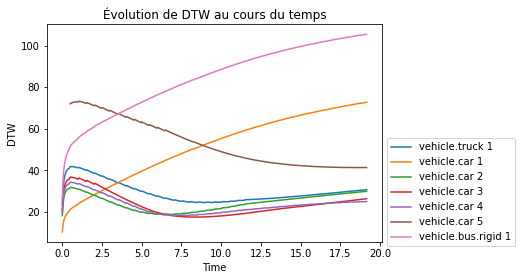

In [36]:
df_DTW_time.plot(x='Time')
plt.legend(loc='best', bbox_to_anchor=(1, 0.5))
plt.ylabel('DTW')
plt.title('Évolution de DTW au cours du temps')

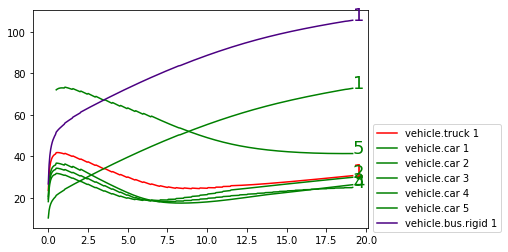

In [78]:
c = [0,'r','g','g','g','g','g','indigo','grey','rosybrown','chartreuse']
for k in range(1,len(df_DTW_time.columns)):
    colonne = df_DTW_time.columns[k]
    plt.plot(df_DTW_time['Time'],df_DTW_time[colonne],label=colonne,color=c[k])
    plt.text(df_DTW_time['Time'].iloc[len(df_DTW_time['Time'])-1], df_DTW_time[colonne].iloc[len(df_DTW_time[colonne])-1],colonne[len(colonne)-1], fontsize=18,color=c[k])
plt.legend(loc='best', bbox_to_anchor=(1, 0.5))

### Étape 11 : Évolution de DTW au cours de la trajectoire  

In [38]:
## En utilisant le package 

#imports nécessaires
import matplotlib.pyplot as plt
from math import sqrt
import datetime 
from datetime import timedelta
from dtw import *
import pandas as pd

def dtw_evolution_espace(scene_name):
    
    # On crée une dataframe vide 
    df = pd.DataFrame()
    
    scene_token = nusc.field2token('scene','name',scene_name)[0]
    sample_token = nusc.field2token('sample','scene_token',scene_token)# Ensemble des token des échantillons de la scene 
    
    # Pour tracer la trajectoire du véhicule ego
    Liste_ego_poses = get_poses(scene_token) 
    X_coord =[]
    Y_coord =[]
    Z_coord =[]
    T_timestamp = [] # liste des timestamps
    for k in range(0,len(Liste_ego_poses)):
        X_coord.append(Liste_ego_poses[k]['translation'][0])
        Y_coord.append(Liste_ego_poses[k]['translation'][1])
        Z_coord.append(Liste_ego_poses[k]['translation'][2])
        T_timestamp.append(Liste_ego_poses[k]['timestamp'])

    # Ensemble des sample_annotation de la scène :
    sample_annotation_token = []
    for k in sample_token : 
        L = nusc.field2token('sample_annotation','sample_token',k)
        sample_annotation_token = sample_annotation_token + L
    
    # On créé la liste des token des instances présents dans les sample_annotation
    L_instance_token = []
    for k in sample_annotation_token :
        exemple = nusc.get('sample_annotation', k)
        L_instance_token.append(exemple['instance_token'])
    # Puisque pour un même objet, on peut avoir plusieurs annotations, on supprime les doublons de L
    L_instance_token = list(set(L_instance_token))
    
    # Liste des catégories d'objet dans la scène 
    L_category_name = []
    for k in sample_annotation_token :
        exemple = nusc.get('sample_annotation', k)
        L_category_name.append(exemple['category_name'])
    L_category_name = list(set(L_category_name)) #on supprime les doublons 
   
    L_vehicule = ['vehicle.bicycle','vehicle.bus.bendy','vehicle.bus.rigid','vehicle.car','vehicle.construction','vehicle.emergency.ambulance','vehicle.emergency.police','vehicle.motorcycle','vehicle.trailer','vehicle.truck']
    
    L_category_name = [k for k in L_category_name if k in L_vehicule]
    
    # Boucle sur chaque catégorie trouvée
    for j in range(0,len(L_category_name)):   
        catego_name = L_category_name[j]
        catego_token = nusc.field2token('category','name',catego_name)
        category = nusc.get('category',catego_token[0])

        # Ensemble des instances appartenant à la fois à la scène et à la catégorie
        L_instance_category = nusc.field2token('instance','category_token',catego_token[0]) # instance dans la catégorie
        L_instance_category = [x for x in L_instance_category if x in L_instance_token]# et dans la scène 
        L_instance_category
        
        # Il peut y avoir plusieurs éléments de la catégorie dans la scène, ici chaque ligne de L représente 
        # les token des sample_annotation pour un élément de cette catégorie. 

        L=[]
        for k in L_instance_category : 
            instance_category = nusc.get('instance',k)
            nbr_annotations = instance_category['nbr_annotations']
            if nbr_annotations == 1:
                L.append([instance_category['first_annotation_token']])
            else : 
                H = []
                first_token = instance_category['first_annotation_token']
                last_token = instance_category['last_annotation_token']
                current_token = first_token 
        
                s = 0 
                while s!= nbr_annotations :
                    current_ann = nusc.get('sample_annotation', current_token)
                    H.append(current_ann['token'])
                    current_token = current_ann['next'] #On passe au suivant
                    s+=1
                L.append(H)
        
        # Maintenant qu'on a les token de tous les sample_annotation pour tous les éléments d'une même catégorie, 
        # on va pouvoir récupérer leurs positions et tracer leurs trajectoires

        X = []
        Y = []
        Z = []
        T_time = []
        for k in L :
            x = []
            y = []
            z = []
            t=[]
            for j in k :
                sample_annotation = nusc.get('sample_annotation',j)
                x.append(sample_annotation['translation'][0])
                y.append(sample_annotation['translation'][1])
                z.append(sample_annotation['translation'][2])
                t.append(nusc.get('sample',sample_annotation['sample_token'])['timestamp'])
            X.append(x)
            Y.append(y)
            Z.append(z)
            T_time.append(t)
    
        # On crée les listes des objets immobiles et mobiles de la catégorie
        Immo, Mobile = immobile(X,Y)
        
        # On conserve uniquement les objets mobiles 
        X_mobile=[X[i] for i in Mobile]
        Y_mobile=[Y[i] for i in Mobile]
        Z_mobile=[Z[i] for i in Mobile]
        T_mobile = [T_time[i] for i in Mobile]
        
        for i in range(0,len(X_mobile)):
            M_distance = Matrice_distance(X_coord,Y_coord,X_mobile[i],Y_mobile[i])
            
            L_test_package_tout=[]
    

            m=1
            n=1

            alignment = dtw(M_distance[0:m,0:n])
            L_test_package_tout.append(alignment.normalizedDistance)

            while n<len(M_distance[0]) and m<len(M_distance):
                n+=1 
                m+=1 

                alignment = dtw(M_distance[0:m,0:n])
                L_test_package_tout.append(alignment.normalizedDistance)
    
            while n<len(M_distance[0]):
                n+=1 
                alignment = dtw(M_distance[0:m,0:n])
                L_test_package_tout.append(alignment.normalizedDistance)
                
            num_colonne = [k for k in range(len(L_test_package_tout))]
            df['num_colonne']=num_colonne   
            nom = catego_name +' '+str(i+1)
            df[nom]= L_test_package_tout 
            
    return df 

In [39]:
df = dtw_evolution_espace(scene_name)
df

,num_colonne,vehicle.truck 1,vehicle.car 1,vehicle.car 2,vehicle.car 3,vehicle.car 4,vehicle.car 5,vehicle.bus.rigid 1
0,0,50.027498,14.857833,44.354934,32.073831,37.864449,65.018774,36.162166
1,1,73.496979,20.025567,65.232483,45.145522,56.748738,95.297152,52.111642
2,2,79.948712,19.690408,71.059477,46.794047,62.957242,103.386690,55.157911
3,3,82.176394,20.016560,73.451025,45.132320,65.976948,106.017518,54.904679
4,4,82.845381,20.313483,74.340058,42.518975,67.704594,106.435397,53.351346
...,...,...,...,...,...,...,...,...
377,377,30.539838,72.461966,29.751618,26.156196,25.046094,41.328140,105.204430
378,378,30.578585,72.527517,29.791601,26.202455,25.048393,41.330119,105.265508
379,379,30.617347,72.592808,29.831644,26.248680,25.051001,41.332328,105.326321
380,380,30.656135,72.657846,29.871769,26.294883,25.052678,41.334779,105.386873


Text(0, 0.5, 'DTW')

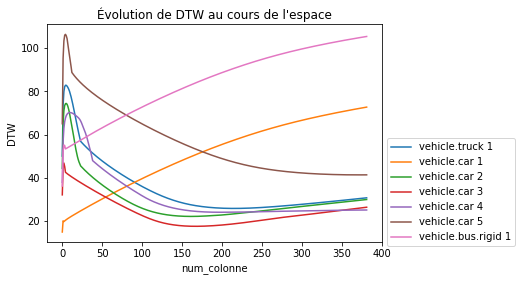

In [40]:
df.plot(x='num_colonne')
plt.legend(loc='best', bbox_to_anchor=(1, 0.5))
plt.title("Évolution de DTW au cours de l'espace")
plt.ylabel('DTW')

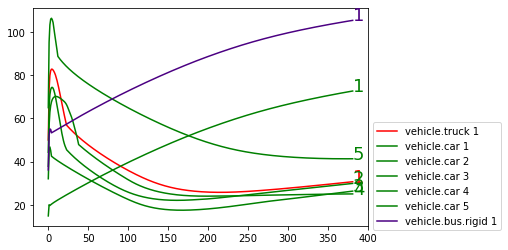

In [79]:
c = [0,'r','g','g','g','g','g','indigo','grey','rosybrown','chartreuse']
for k in range(1,len(df.columns)):
    colonne = df.columns[k]
    plt.plot(df['num_colonne'],df[colonne],label=colonne,color=c[k])
    plt.text(df['num_colonne'].iloc[len(df['num_colonne'])-1], df[colonne].iloc[len(df[colonne])-1],colonne[len(colonne)-1], fontsize=18,color=c[k])
plt.legend(loc='best', bbox_to_anchor=(1, 0.5))

### Étape 12 : Analyse de la matrice des distances 

In [42]:
import numpy as np 
from math import sqrt 

# Fonction qui renvoie la matrice des distances 
def Matrice_distance(X_ego,Y_ego,X_veh,Y_veh):
    M = np.zeros((len(X_veh),len(X_ego)))
    for i in range(0,len(X_veh)):
        for j in range(0,len(X_ego)):
            M[i,j] = sqrt((X_veh[len(X_veh)-1-i]-X_ego[j])**2+(Y_veh[len(Y_veh)-1-i]-Y_ego[j])**2)
    return M 

In [43]:
## Fonction qui renvoie des infos sur les distances entre les points de trajectoires des véhicules et du véhicule ego

#imports nécessaires
import matplotlib.pyplot as plt
from math import sqrt
import datetime 
from datetime import timedelta
from dtw import *
import pandas as pd

def analyse_mat_distance(scene_name):
    
    # On crée une dataframe vide 
    df = pd.DataFrame()
    
    scene_token = nusc.field2token('scene','name',scene_name)[0]
    sample_token = nusc.field2token('sample','scene_token',scene_token)# Ensemble des token des échantillons de la scene 
    
    # Pour tracer la trajectoire du véhicule ego
    Liste_ego_poses = get_poses(scene_token) 
    X_coord =[]
    Y_coord =[]
    Z_coord =[]
    T_timestamp = [] # liste des timestamps
    for k in range(0,len(Liste_ego_poses)):
        X_coord.append(Liste_ego_poses[k]['translation'][0])
        Y_coord.append(Liste_ego_poses[k]['translation'][1])
        Z_coord.append(Liste_ego_poses[k]['translation'][2])
        T_timestamp.append(Liste_ego_poses[k]['timestamp'])

    # Ensemble des sample_annotation de la scène :
    sample_annotation_token = []
    for k in sample_token : 
        L = nusc.field2token('sample_annotation','sample_token',k)
        sample_annotation_token = sample_annotation_token + L
    
    # On créé la liste des token des instances présents dans les sample_annotation
    L_instance_token = []
    for k in sample_annotation_token :
        exemple = nusc.get('sample_annotation', k)
        L_instance_token.append(exemple['instance_token'])
    # Puisque pour un même objet, on peut avoir plusieurs annotations, on supprime les doublons de L
    L_instance_token = list(set(L_instance_token))
    
    # Liste des catégories d'objet dans la scène 
    L_category_name = []
    for k in sample_annotation_token :
        exemple = nusc.get('sample_annotation', k)
        L_category_name.append(exemple['category_name'])
    L_category_name = list(set(L_category_name)) #on supprime les doublons 
   
    L_vehicule = ['vehicle.bicycle','vehicle.bus.bendy','vehicle.bus.rigid','vehicle.car','vehicle.construction','vehicle.emergency.ambulance','vehicle.emergency.police','vehicle.motorcycle','vehicle.trailer','vehicle.truck']
    
    L_category_name = [k for k in L_category_name if k in L_vehicule]
    
    #Colonnes de la df 
    L_veh = []
    L_nbr_zero = []
    L_dist_min = []
    L_dist_max = []
    L_dist_moy = []
    L_DTW = []
    L_dist_parcourue = []
    
    # Boucle sur chaque catégorie trouvée
    for j in range(0,len(L_category_name)):   
        catego_name = L_category_name[j]
        catego_token = nusc.field2token('category','name',catego_name)
        category = nusc.get('category',catego_token[0])

        # Ensemble des instances appartenant à la fois à la scène et à la catégorie
        L_instance_category = nusc.field2token('instance','category_token',catego_token[0]) # instance dans la catégorie
        L_instance_category = [x for x in L_instance_category if x in L_instance_token]# et dans la scène 
        L_instance_category
        
        # Il peut y avoir plusieurs éléments de la catégorie dans la scène, ici chaque ligne de L représente 
        # les token des sample_annotation pour un élément de cette catégorie. 

        L=[]
        for k in L_instance_category : 
            instance_category = nusc.get('instance',k)
            nbr_annotations = instance_category['nbr_annotations']
            if nbr_annotations == 1:
                L.append([instance_category['first_annotation_token']])
            else : 
                H = []
                first_token = instance_category['first_annotation_token']
                last_token = instance_category['last_annotation_token']
                current_token = first_token 
        
                s = 0 
                while s!= nbr_annotations :
                    current_ann = nusc.get('sample_annotation', current_token)
                    H.append(current_ann['token'])
                    current_token = current_ann['next'] #On passe au suivant
                    s+=1
                L.append(H)
        
        # Maintenant qu'on a les token de tous les sample_annotation pour tous les éléments d'une même catégorie, 
        # on va pouvoir récupérer leurs positions et tracer leurs trajectoires

        X = []
        Y = []
        Z = []
        T_time = []
        for k in L :
            x = []
            y = []
            z = []
            t=[]
            for j in k :
                sample_annotation = nusc.get('sample_annotation',j)
                x.append(sample_annotation['translation'][0])
                y.append(sample_annotation['translation'][1])
                z.append(sample_annotation['translation'][2])
                t.append(nusc.get('sample',sample_annotation['sample_token'])['timestamp'])
            X.append(x)
            Y.append(y)
            Z.append(z)
            T_time.append(t)
    
        # On crée les listes des objets immobiles et mobiles de la catégorie
        Immo, Mobile = immobile(X,Y)
        
        # On conserve uniquement les objets mobiles 
        X_mobile=[X[i] for i in Mobile]
        Y_mobile=[Y[i] for i in Mobile]
        Z_mobile=[Z[i] for i in Mobile]
        T_mobile = [T_time[i] for i in Mobile]
        
        for i in range(0,len(X_mobile)):
            nom = catego_name +' '+str(i+1)
            L_veh.append(nom)
            
            M_distance = Matrice_distance(X_coord,Y_coord,X_mobile[i],Y_mobile[i])
            
            L_nbr_zero.append(np.count_nonzero(M_distance==0))
            L_dist_min.append(M_distance.min())
            L_dist_max.append(M_distance.max()) 
            L_dist_moy.append(M_distance.mean()) 
            
            alignment = dtw(M_distance)
            distance = alignment.normalizedDistance
            L_DTW.append(distance)
            
            # pour la distance totale parcourue, on utilise la fonction construite plus haut
            L_dist_parcourue.append(distance_parcourue(X_mobile[i],Y_mobile[i],Z_mobile[i]))
            

    df['Véhicules'] = L_veh
    df['Nbr de 0'] = L_nbr_zero
    df['Distance min'] = L_dist_min
    df['Distance max'] = L_dist_max
    df['Distance moyenne'] = L_dist_moy
    df['Distance parcourue'] = L_dist_parcourue
    df['DTW'] = L_DTW

    return df

In [44]:
df_mat_distance = analyse_mat_distance(scene_name)
df_mat_distance

,Véhicules,Nbr de 0,Distance min,Distance max,Distance moyenne,Distance parcourue,DTW
0,vehicle.truck 1,0,8.451707,100.054996,46.821779,76.396551,30.694937
1,vehicle.car 1,0,20.739661,106.205203,77.747443,9.928996,72.722629
2,vehicle.car 2,0,6.787707,88.709867,37.541805,66.096711,29.911894
3,vehicle.car 3,0,4.476506,64.147662,27.122438,22.742113,26.341053
4,vehicle.car 4,0,0.037589,77.803221,25.983685,61.636480,25.051878
5,vehicle.car 5,0,23.749359,130.037548,60.786182,49.272339,41.337471
6,vehicle.bus.rigid 1,0,53.479254,146.866323,115.609867,18.962743,105.447162


#### Tracer DTW en fonction d'autres valeurs 

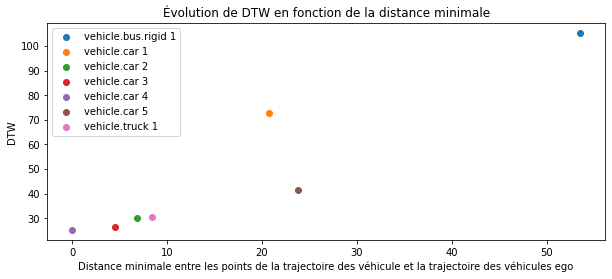

In [45]:
# DTW en fonction de la distance minimale entre la trajectoire des véhicules
# et du véhicule ego 

fig, ax = plt.subplots(figsize=(10,4))
for key, grp in df_mat_distance.groupby(['Véhicules']):
    ax.scatter(grp['Distance min'], grp['DTW'], label=key)

ax.legend()
plt.xlabel('Distance minimale entre les points de la trajectoire des véhicule et la trajectoire des véhicules ego')
plt.ylabel('DTW')
plt.title('Évolution de DTW en fonction de la distance minimale')
plt.show()


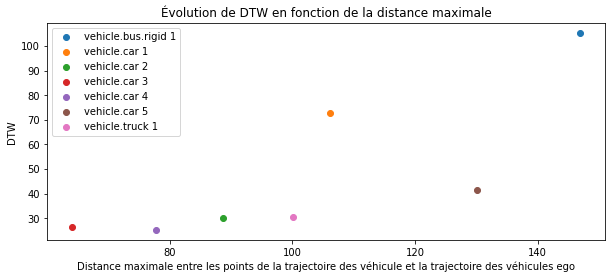

In [46]:
# DTW en fonction de la distance maximale entre la trajectoire des véhicules
# et du véhicule ego 

fig, ax = plt.subplots(figsize=(10,4))
for key, grp in df_mat_distance.groupby(['Véhicules']):
    ax.scatter(grp['Distance max'], grp['DTW'], label=key)

ax.legend()
plt.xlabel('Distance maximale entre les points de la trajectoire des véhicule et la trajectoire des véhicules ego')
plt.ylabel('DTW')
plt.title('Évolution de DTW en fonction de la distance maximale')
plt.show()

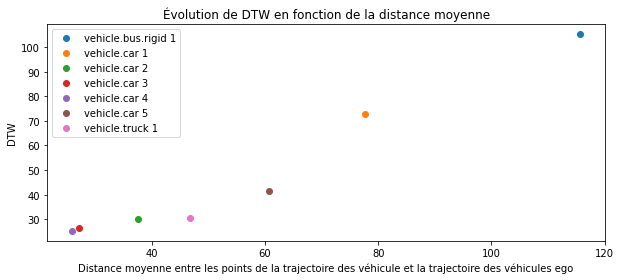

In [47]:
# DTW en fonction de la distance moyenne entre la trajectoire des véhicules
# et du véhicule ego 

fig, ax = plt.subplots(figsize=(10,4))
for key, grp in df_mat_distance.groupby(['Véhicules']):
    ax.scatter(grp['Distance moyenne'], grp['DTW'], label=key)

ax.legend()
plt.xlabel('Distance moyenne entre les points de la trajectoire des véhicule et la trajectoire des véhicules ego')
plt.ylabel('DTW')
plt.title('Évolution de DTW en fonction de la distance moyenne')
plt.show()

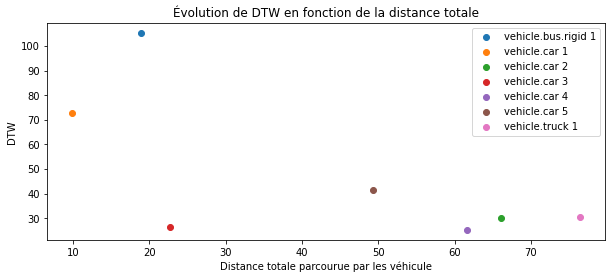

In [48]:
# DTW en fonction de la distance totale parcourue par les véhicules
fig, ax = plt.subplots(figsize=(10,4))
for key, grp in df_mat_distance.groupby(['Véhicules']):
    ax.scatter(grp['Distance parcourue'], grp['DTW'], label=key)

ax.legend()
plt.xlabel('Distance totale parcourue par les véhicule')
plt.ylabel('DTW')
plt.title('Évolution de DTW en fonction de la distance totale')
plt.show()

### Étape 13 : DTW pour les vitesses des véhicules

In [49]:
import numpy as np

def suiveur(X_ego,Y_ego,X_veh,Y_veh):
    V1 = np.array([X_ego[0]-X_veh[0],Y_ego[0]-Y_veh[0]])
    V2 = np.array([X_veh[1]-X_veh[0],Y_veh[1]-Y_veh[0]])
    PC = np.vdot(V1,V2)
    if PC >0 :
        return 0 # Le véhicule suit le véhicule ego
    elif PC<0 :
        return 1 # Le véhicule ego suit le véhicule
    else : 
        return 2 # On est parallèle au départ 
    
# La fonction permet de savoir si un véhicule donné dans la scène suit ou non le véhicule ego à partir des coordonnées
# des deux véhicules dans l'espace. La fonction renvoie :
# - 0 si le véhicule suit le véhicule ego
# - 1 si le vehicule est suivit pas le véhicule égo 
# - 2 si les véhicules sont parallèles au départ

In [50]:
## En utilisant le package 

#imports nécessaires
import matplotlib.pyplot as plt
from math import sqrt
import datetime 
from datetime import timedelta
from dtw import *
import pandas as pd

def dtw_vitesse(scene_name):
    
    # On crée une dataframe vide 
    df = pd.DataFrame()
    
    scene_token = nusc.field2token('scene','name',scene_name)[0]
    sample_token = nusc.field2token('sample','scene_token',scene_token)# Ensemble des token des échantillons de la scene 
    
    # Pour tracer la trajectoire du véhicule ego
    Liste_ego_poses = get_poses(scene_token) 
    X_coord =[]
    Y_coord =[]
    Z_coord =[]
    T_timestamp = [] # liste des timestamps
    for k in range(0,len(Liste_ego_poses)):
        X_coord.append(Liste_ego_poses[k]['translation'][0])
        Y_coord.append(Liste_ego_poses[k]['translation'][1])
        Z_coord.append(Liste_ego_poses[k]['translation'][2])
        T_timestamp.append(Liste_ego_poses[k]['timestamp'])
        
        
    # On va faire le vecteur des vitesses instantannées du véhicule ego
    D =[0]
    T=[0]
    for k in range(0,len(T_timestamp)-1):
        d = D[k]+ sqrt((X_coord[k+1]-X_coord[k])**2+(Y_coord[k+1]-Y_coord[k])**2+(Z_coord[k+1]-Z_coord[k])**2)
        D.append(d)
        t2 = datetime.datetime.fromtimestamp(T_timestamp[k+1]/ 1e6)
        t1 = datetime.datetime.fromtimestamp(T_timestamp[k]/ 1e6)
        t = T[k]+(t2-t1).total_seconds() 
        T.append(t)
    V_ego = [D[k]/T[k] for k in range(1,len(T))]    
    
    # Ensemble des sample_annotation de la scène :
    sample_annotation_token = []
    for k in sample_token : 
        L = nusc.field2token('sample_annotation','sample_token',k)
        sample_annotation_token = sample_annotation_token + L
    
    # On créé la liste des token des instances présents dans les sample_annotation
    L_instance_token = []
    for k in sample_annotation_token :
        exemple = nusc.get('sample_annotation', k)
        L_instance_token.append(exemple['instance_token'])
    # Puisque pour un même objet, on peut avoir plusieurs annotations, on supprime les doublons de L
    L_instance_token = list(set(L_instance_token))
    
    # Liste des catégories d'objet dans la scène 
    L_category_name = []
    for k in sample_annotation_token :
        exemple = nusc.get('sample_annotation', k)
        L_category_name.append(exemple['category_name'])
    L_category_name = list(set(L_category_name)) #on supprime les doublons 
   
    L_vehicule = ['vehicle.bicycle','vehicle.bus.bendy','vehicle.bus.rigid','vehicle.car','vehicle.construction','vehicle.emergency.ambulance','vehicle.emergency.police','vehicle.motorcycle','vehicle.trailer','vehicle.truck']
    
    L_category_name = [k for k in L_category_name if k in L_vehicule]
    
    # Boucle sur chaque catégorie trouvée
    for j in range(0,len(L_category_name)):   
        catego_name = L_category_name[j]
        catego_token = nusc.field2token('category','name',catego_name)
        category = nusc.get('category',catego_token[0])

        # Ensemble des instances appartenant à la fois à la scène et à la catégorie
        L_instance_category = nusc.field2token('instance','category_token',catego_token[0]) # instance dans la catégorie
        L_instance_category = [x for x in L_instance_category if x in L_instance_token]# et dans la scène 
        L_instance_category
        
        # Il peut y avoir plusieurs éléments de la catégorie dans la scène, ici chaque ligne de L représente 
        # les token des sample_annotation pour un élément de cette catégorie. 

        L=[]
        for k in L_instance_category : 
            instance_category = nusc.get('instance',k)
            nbr_annotations = instance_category['nbr_annotations']
            if nbr_annotations == 1:
                L.append([instance_category['first_annotation_token']])
            else : 
                H = []
                first_token = instance_category['first_annotation_token']
                last_token = instance_category['last_annotation_token']
                current_token = first_token 
        
                s = 0 
                while s!= nbr_annotations :
                    current_ann = nusc.get('sample_annotation', current_token)
                    H.append(current_ann['token'])
                    current_token = current_ann['next'] #On passe au suivant
                    s+=1
                L.append(H)
        
        # Maintenant qu'on a les token de tous les sample_annotation pour tous les éléments d'une même catégorie, 
        # on va pouvoir récupérer leurs positions et tracer leurs trajectoires

        X = []
        Y = []
        Z = []
        T_time = []
        for k in L :
            x = []
            y = []
            z = []
            t=[]
            for j in k :
                sample_annotation = nusc.get('sample_annotation',j)
                x.append(sample_annotation['translation'][0])
                y.append(sample_annotation['translation'][1])
                z.append(sample_annotation['translation'][2])
                t.append(nusc.get('sample',sample_annotation['sample_token'])['timestamp'])
            X.append(x)
            Y.append(y)
            Z.append(z)
            T_time.append(t)
    
        # On crée les listes des objets immobiles et mobiles de la catégorie
        Immo, Mobile = immobile(X,Y)
        
        # On conserve uniquement les objets mobiles 
        X_mobile=[X[i] for i in Mobile]
        Y_mobile=[Y[i] for i in Mobile]
        Z_mobile=[Z[i] for i in Mobile]
        T_mobile = [T_time[i] for i in Mobile]
        
        for i in range(0,len(X_mobile)):
            d=[0]
            t_time=[0]
            for k in range(0,len(X_mobile[i])-1):
                d.append(d[k]+sqrt((X_mobile[i][k+1]-X_mobile[i][k])**2+(Y_mobile[i][k+1]-Y_mobile[i][k])**2+(Z_mobile[i][k+1]-Z_mobile[i][k])**2))
                t2 = datetime.datetime.fromtimestamp(T_mobile[i][k+1]/ 1e6) # on met les timestamp en datetime
                t1 = datetime.datetime.fromtimestamp(T_mobile[i][k]/ 1e6)
                t = t_time[k]+(t2-t1).total_seconds() # On récupère le temps en seconde 
                t_time.append(t)
           
            v_catego = [d[k]/t_time[k] for k in range(1,len(t_time))]

            alignment = dtw(v_catego,V_ego)
            #distance = alignment.normalizedDistance
            distance = alignment.distance
           
            nom = catego_name +' '+str(i+1)
            df[nom]=[distance]
            
            I =[i for i in range(0,len(v_catego))]
            plt.plot(t_time[1:],v_catego,label =nom)

    plt.plot(T[1:],V_ego,linestyle='-.',label='Veh ego')
    plt.xlabel('Temps (en s)')
    plt.ylabel('Vitesse (en m/s)')
    plt.title('Évolution de la vitesse des véhicules au cours du temps')
    plt.legend(bbox_to_anchor=(1.5, 1.0),loc='best')

    return df

,vehicle.truck 1,vehicle.car 1,vehicle.car 2,vehicle.car 3,vehicle.car 4,vehicle.car 5,vehicle.bus.rigid 1
0,507.345853,1052.295457,595.972971,1682.676531,621.273026,494.486693,974.873238


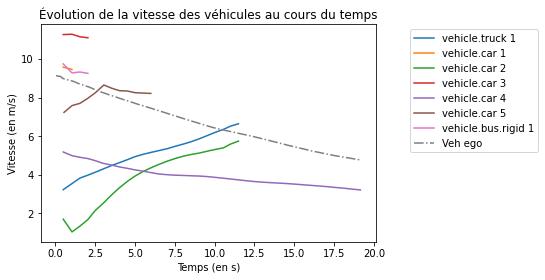

In [51]:
dtw_vitesse(scene_name)

In [ ]:
# Les courbes de vitesse ont l'air cohérentes, on a des vitesses au max de 10-12 m/s ce qui correspond à 35-45 km/h
# Pour ce qui est des résultats de DTW, on a pas des résultats qui permettent de voir que les véhicules se suivent

### Étape 14 : Évolution du % de DTW pour dans le temps 

In [138]:
# On va utiliser la fonction dtw_distance_temps

In [102]:
import math

def DTW_pourcentage(scene_name):
    df_DTW_time = dtw_distance_temps(scene_name)
    columns = df_DTW_time.columns
    
    df_pourcentage = pd.DataFrame()
    df_pourcentage['Time']=df_DTW_time['Time']
    
    for k in range(1,len(columns)):
        L = []
        for j in range(0,len(df_DTW_time)):
            if  math.isnan(df_DTW_time.iloc[j][k]):
                L.append(np.nan)
            else : 
                s=0 
                for i in range(1,len(df_DTW_time.iloc[j])):
                    if not math.isnan(df_DTW_time.iloc[j][i]):
                        s+=df_DTW_time.iloc[j][i]
                #L.append(df_DTW_time.iloc[j][k]/s*100)
                L.append(df_DTW_time.iloc[j][k])
        df_pourcentage[columns[k]]=L
    
    return df_pourcentage

In [103]:
df_pourcentage=DTW_pourcentage(scene_name)
df_pourcentage

,Time,vehicle.truck 1,vehicle.car 1,vehicle.car 2,vehicle.car 3,vehicle.car 4,vehicle.car 5,vehicle.bus.rigid 1
0,0.000000,23.600622,10.369830,18.221448,20.707349,19.515424,NaN,26.739627
1,0.049801,31.317305,13.962687,24.145584,27.458585,25.869165,NaN,35.802713
2,0.099538,35.063525,15.861619,26.995943,30.721268,28.932880,NaN,40.446352
3,0.149855,37.220547,17.083989,28.615784,32.587530,30.679651,NaN,43.323110
4,0.200646,38.582557,17.968648,29.619961,33.755169,31.767559,NaN,45.316813
...,...,...,...,...,...,...,...,...
377,18.949395,30.539838,72.461966,29.751618,26.156196,24.924260,41.328140,105.204430
378,18.999167,30.578585,72.527517,29.791601,26.202455,24.926857,41.330119,105.265508
379,19.050087,30.617347,72.592808,29.831644,26.248680,24.929762,41.332328,105.326321
380,19.099263,30.656135,72.657846,29.871769,26.294883,24.931732,41.334779,105.386873


Text(0, 0.5, '% de DTW')

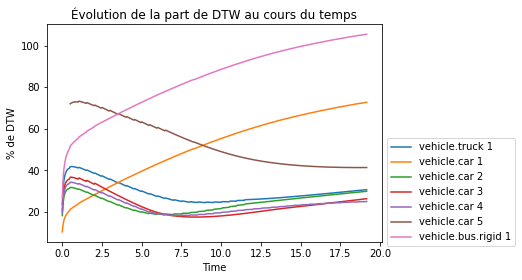

In [104]:
df_pourcentage.plot(x='Time')
plt.legend(loc='best', bbox_to_anchor=(1, 0.5))
plt.title("Évolution de la part de DTW au cours du temps")
plt.ylabel('% de DTW')

Text(0.5, 1.0, 'Évolution de la part de DTW au cours du temps')

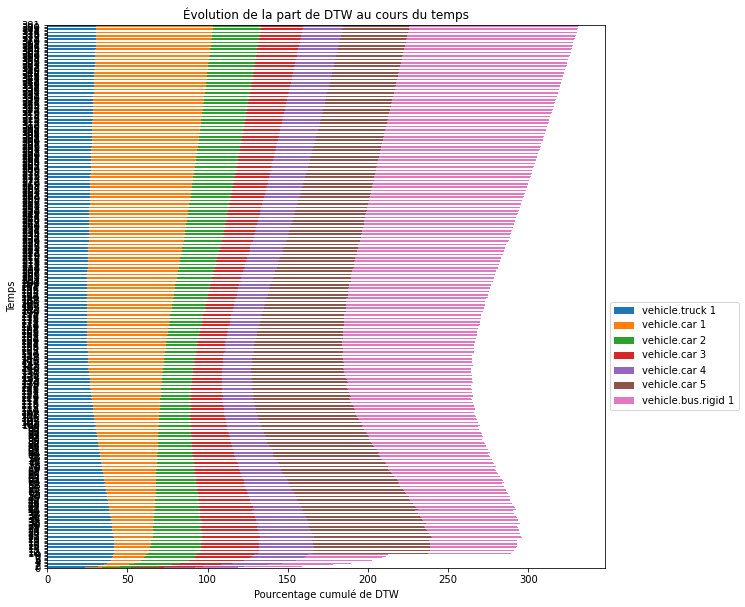

In [105]:
df_new = df_pourcentage.drop(columns=['Time'])
df_new.plot.barh(stacked = True,figsize=(10,10))
plt.legend(loc='best', bbox_to_anchor=(1, 0.5))
plt.xlabel('Pourcentage cumulé de DTW')
plt.ylabel('Temps')
plt.title("Évolution de la part de DTW au cours du temps")

### Étape 15 : Nombre de point associé à un même point

In [73]:
## Fonction sur la recurrence des points dans le chemin optimal 

#imports nécessaires
import matplotlib.pyplot as plt
from math import sqrt
import datetime 
from datetime import timedelta
from dtw import *
import pandas as pd

def dtw_recurrence_point(scene_name):
    
    # On crée une dataframe vide 
    df_x = pd.DataFrame()
    df_y = pd.DataFrame()
    
    scene_token = nusc.field2token('scene','name',scene_name)[0]
    sample_token = nusc.field2token('sample','scene_token',scene_token)# Ensemble des token des échantillons de la scene 
    
    # Pour tracer la trajectoire du véhicule ego
    Liste_ego_poses = get_poses(scene_token) 
    X_coord =[]
    Y_coord =[]
    Z_coord =[]
    T_timestamp = [] # liste des timestamps
    for k in range(0,len(Liste_ego_poses)):
        X_coord.append(Liste_ego_poses[k]['translation'][0])
        Y_coord.append(Liste_ego_poses[k]['translation'][1])
        Z_coord.append(Liste_ego_poses[k]['translation'][2])
        T_timestamp.append(Liste_ego_poses[k]['timestamp'])

    # Ensemble des sample_annotation de la scène :
    sample_annotation_token = []
    for k in sample_token : 
        L = nusc.field2token('sample_annotation','sample_token',k)
        sample_annotation_token = sample_annotation_token + L
    
    # On créé la liste des token des instances présents dans les sample_annotation
    L_instance_token = []
    for k in sample_annotation_token :
        exemple = nusc.get('sample_annotation', k)
        L_instance_token.append(exemple['instance_token'])
    # Puisque pour un même objet, on peut avoir plusieurs annotations, on supprime les doublons de L
    L_instance_token = list(set(L_instance_token))
    
    # Liste des catégories d'objet dans la scène 
    L_category_name = []
    for k in sample_annotation_token :
        exemple = nusc.get('sample_annotation', k)
        L_category_name.append(exemple['category_name'])
    L_category_name = list(set(L_category_name)) #on supprime les doublons 
   
    L_vehicule = ['vehicle.bicycle','vehicle.bus.bendy','vehicle.bus.rigid','vehicle.car','vehicle.construction','vehicle.emergency.ambulance','vehicle.emergency.police','vehicle.motorcycle','vehicle.trailer','vehicle.truck']
    
    L_category_name = [k for k in L_category_name if k in L_vehicule]
    
    L_nom = []
    L_x_chemin = []
    L_y_chemin = []
    
    # Boucle sur chaque catégorie trouvée
    for j in range(0,len(L_category_name)):   
        catego_name = L_category_name[j]
        catego_token = nusc.field2token('category','name',catego_name)
        category = nusc.get('category',catego_token[0])

        # Ensemble des instances appartenant à la fois à la scène et à la catégorie
        L_instance_category = nusc.field2token('instance','category_token',catego_token[0]) # instance dans la catégorie
        L_instance_category = [x for x in L_instance_category if x in L_instance_token]# et dans la scène 
        L_instance_category
        
        # Il peut y avoir plusieurs éléments de la catégorie dans la scène, ici chaque ligne de L représente 
        # les token des sample_annotation pour un élément de cette catégorie. 

        L=[]
        for k in L_instance_category : 
            instance_category = nusc.get('instance',k)
            nbr_annotations = instance_category['nbr_annotations']
            if nbr_annotations == 1:
                L.append([instance_category['first_annotation_token']])
            else : 
                H = []
                first_token = instance_category['first_annotation_token']
                last_token = instance_category['last_annotation_token']
                current_token = first_token 
        
                s = 0 
                while s!= nbr_annotations :
                    current_ann = nusc.get('sample_annotation', current_token)
                    H.append(current_ann['token'])
                    current_token = current_ann['next'] #On passe au suivant
                    s+=1
                L.append(H)
        
        # Maintenant qu'on a les token de tous les sample_annotation pour tous les éléments d'une même catégorie, 
        # on va pouvoir récupérer leurs positions et tracer leurs trajectoires

        X = []
        Y = []
        Z = []
        T_time = []
        for k in L :
            x = []
            y = []
            z = []
            t=[]
            for j in k :
                sample_annotation = nusc.get('sample_annotation',j)
                x.append(sample_annotation['translation'][0])
                y.append(sample_annotation['translation'][1])
                z.append(sample_annotation['translation'][2])
                t.append(nusc.get('sample',sample_annotation['sample_token'])['timestamp'])
            X.append(x)
            Y.append(y)
            Z.append(z)
            T_time.append(t)
    
        # On crée les listes des objets immobiles et mobiles de la catégorie
        Immo, Mobile = immobile(X,Y)
        
        # On conserve uniquement les objets mobiles 
        X_mobile=[X[i] for i in Mobile]
        Y_mobile=[Y[i] for i in Mobile]
        Z_mobile=[Z[i] for i in Mobile]
        T_mobile = [T_time[i] for i in Mobile]
        
        for i in range(0,len(X_mobile)):
            nom = catego_name +' '+str(i+1)
            L_nom.append(nom)
            
            M_distance = Matrice_distance(X_coord,Y_coord,X_mobile[i],Y_mobile[i])
            alignment = dtw(M_distance)
            distance = alignment.normalizedDistance
            
            x_chemin = list(alignment.index1)
            L1 = [x_chemin.count(x) for x in list(set(x_chemin))]
            L_x_chemin.append(L1)
            y_chemin = list(alignment.index2)
            L2 = [y_chemin.count(x) for x in list(set(y_chemin))]
            L_y_chemin.append(L2)
    
    max_Lx = max([len(x) for x in L_x_chemin])
    max_Ly = max([len(x) for x in L_y_chemin])
    df_x['Récurrence du point'] = [k for k in range(0,max_Lx)]
    df_y['Récurrence du point'] = [k for k in range(0,max_Ly)]
    
    
    for k in range(0,len(L_x_chemin)):
        
        while len(L_x_chemin[k])<max_Lx:
            L_x_chemin[k].append(np.nan)
        df_x[L_nom[k]] = L_x_chemin[k]
        
        while len(L_y_chemin[k])<max_Ly:
            L_y_chemin[k].append(np.nan)
        df_y[L_nom[k]] = L_y_chemin[k]

    return df_x,df_y

In [74]:
df_x,df_y = dtw_recurrence_point(scene_name)
# Le soucis c'est que tous les véhicules n'ont pas le même nombre de pt
# Donc dans la df, on arrive pas à récupérer certaines données
# IL faut donc déterminer le max pour les x et mettre des NaN ou on a pas
# de valeurs 

In [75]:
df_x

,Récurrence du point,vehicle.truck 1,vehicle.car 1,vehicle.car 2,vehicle.car 3,vehicle.car 4,vehicle.car 5,vehicle.bus.rigid 1
0,0,1.0,1.0,1.0,1.0,1,1.0,1.0
1,1,1.0,1.0,1.0,1.0,1,1.0,1.0
2,2,1.0,382.0,1.0,1.0,1,1.0,1.0
3,3,1.0,NaN,1.0,381.0,1,1.0,1.0
4,4,1.0,NaN,1.0,1.0,1,1.0,382.0
5,5,1.0,NaN,1.0,NaN,1,1.0,NaN
6,6,1.0,NaN,1.0,NaN,1,1.0,NaN
7,7,1.0,NaN,1.0,NaN,1,1.0,NaN
8,8,1.0,NaN,1.0,NaN,1,1.0,NaN
9,9,1.0,NaN,1.0,NaN,1,1.0,NaN


In [76]:
df_y

,Récurrence du point,vehicle.truck 1,vehicle.car 1,vehicle.car 2,vehicle.car 3,vehicle.car 4,vehicle.car 5,vehicle.bus.rigid 1
0,0,22,3,15,3,24,12,5
1,1,1,1,1,1,1,1,1
2,2,1,1,1,1,1,1,1
3,3,1,1,1,1,1,1,1
4,4,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...
377,377,1,1,1,1,1,1,1
378,378,1,1,1,1,1,1,1
379,379,1,1,1,1,1,1,1
380,380,1,1,1,1,1,1,1
